In [1]:
import pandas
import numpy as np
import pyproj
import math

(1912, 2940, 4)


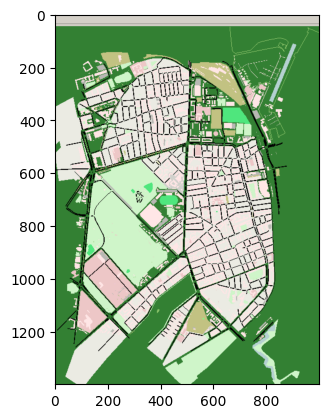

In [41]:
import matplotlib.pyplot as plt
img = plt.imread("/Users/carlo/Desktop/map.png")
print(img.shape)
img_y = int((img.shape[0]/2) -700)
img_y_end = int((img.shape[0]/2) +700)
img_x = int(img.shape[1]/2)
img_x_end = img_x + 1000
img_cropped = img[img_y:img_y_end, img_x:img_x_end, :]
plt.imshow(img_cropped)

In [5]:
df = pandas.read_parquet("./osterbro.parquet")
df.head()

# NOTE
# x and y are swapped in the file
# y is latitude (hence x)

,id,NOx,electricity,type,x,y,time,timedelta
0,truck0,0.0,0.00,truck_hybrid,1008.35,2011.40,2022-01-01 00:00:00,0
1,veh0,0.0,1.27,veh_ev,1181.15,389.73,2022-01-01 00:00:00,0
2,truck0,0.0,0.00,truck_hybrid,1009.30,2011.69,2022-01-01 00:00:01,1
3,veh0,0.0,-3.24,veh_ev,1169.73,398.01,2022-01-01 00:00:01,1
4,truck0,0.0,0.00,truck_hybrid,1010.94,2012.18,2022-01-01 00:00:02,2


In [6]:
df['type'].unique()

array(['truck_hybrid', 'veh_ev', 'truck_gas'], dtype=object)

In [63]:
print("Fixing coordinates swapped")
for i, vehicle in df.iterrows():
    tmp = df.at[i, 'x']
    df.at[i, 'x'] = df.at[i, 'y']
    df.at[i, 'y'] = tmp
print("Done")
df.to_parquet('./emission_corrected.parquet')

Fixing coordinates swapped
Done


In [40]:
timeSteps = np.max(df['time'].unique())
print(timeSteps)

4021.0


In [24]:
def coordinate_deg_to_meters(lon, lat):
    y = lat * 111320.0 #1 degree = 111.32km
    x = lon * 40075000.0 * math.cos(lat * math.pi / 180.0) / (2 * math.pi)
    return (x, y)

In [30]:
firstVehicle = df[df['time'] == 0].loc[0]
print(df.loc)
print(coordinate_deg_to_meters(firstVehicle.x, firstVehicle.y))

(45180488.46643454, 6201437.49192)


In [35]:
print("Converting coordinates from degrees to meters...")
for i, vehicle in df.iterrows():
    x, y = coordinate_deg_to_meters(vehicle.x, vehicle.y)
    df.at[i, 'x'] = x
    df.at[i, 'y'] = y
print("Done")

Converting coordinates from degrees to meters...
Done


In [66]:
#df.head()
print(df[df['id'] == 'truck0'])

           id    NOx  electricity          type          x          y   time
0      truck0  38.95          0.0  truck_petrol  55.708206  12.572871    0.0
2      truck0  41.67          0.0  truck_petrol  55.708209  12.572886    1.0
4      truck0  42.54          0.0  truck_petrol  55.708214  12.572912    2.0
6      truck0  48.50          0.0  truck_petrol  55.708223  12.572956    3.0
9      truck0  49.86          0.0  truck_petrol  55.708234  12.573015    4.0
...       ...    ...          ...           ...        ...        ...    ...
17880  truck0  41.47          0.0  truck_petrol  55.713082  12.579873  236.0
18016  truck0  41.76          0.0  truck_petrol  55.713079  12.579791  237.0
18152  truck0  46.58          0.0  truck_petrol  55.713078  12.579703  238.0
18287  truck0  40.61          0.0  truck_petrol  55.713076  12.579616  239.0
18423  truck0   0.00          0.0  truck_petrol  55.713075  12.579533  240.0

[241 rows x 7 columns]


In [69]:
# Projection
min_x = df['x'].min()
max_x = df['x'].max()
min_y = df['y'].min()
max_y = df['y'].max()
resolution = max(max_x - min_x, max_y - min_y)
mapWidth = 40
mapHeight = 40
cellSize = 17
padding_top = (1.0 - ((max_y - min_y) / resolution)) * mapHeight * cellSize / 2
padding_left = (1.0 - ((max_x - min_x) / resolution)) * mapWidth * cellSize / 2
print(padding_top)
print(padding_left)

# Mapping first vehicle
print(padding_left + ((df.loc[0].x - min_x) / resolution)* mapWidth * cellSize)
print(padding_top + ((df.loc[0].y - min_y) / resolution) * mapHeight * cellSize)

0.0
81.88180671788642
432.8734380373308
286.40605296341533
